In [1]:
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
import keras

/home/ganthony/anaconda3/envs/tensorflow/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.
/home/ganthony/anaconda3/envs/tensorflow/lib/python3.6/importlib/_bootstrap.py:219: RuntimeWarning: numpy.dtype size changed, may indicate binary incompatibility. Expected 96, got 88
  return f(*args, **kwds)


In [3]:
def dice(im1, im2):
    
    '''
    Do we match the binary version of the prediction mask or the probability version?
    '''
    
    im1 = np.asarray(im1)
    im2 = np.asarray(im2)

    if im1.shape != im2.shape:
        raise ValueError("Shape mismatch: im1 and im2 must have the same shape.")

    # Compute Dice coefficient
    intersection = im1*im2

    smoothing_delta = 1.0
    
    return (2. * intersection.sum() + smoothing_delta) / (im1.sum() + im2.sum() + smoothing_delta)

In [4]:
dir1 = '/mnt/data/medical/brats/all_slices/Results/'
keras_model = dir1+"unet_model_upsampling_CROPPEDX8_CROPPEDY8.hdf5"
test = np.load(dir1+'msks_test.npy')
imgs = np.load(dir1+'imgs_test.npy')

In [5]:
# Preprocess the segmentation masks for the ground truth (mode=1)
test[:,:,:,0] = test[:,:,:,0]+test[:,:,:,1]+test[:,:,:,2]+test[:,:,:,3]

In [6]:
model = keras.models.load_model(keras_model)


In [7]:
cropdim = 8  # Needs to be a multiple of 8 because of the upsampling
offsetx = 0   # Needs to be less than the cropdim
offsety = 0   # Needs to be less than the cropdim

x_size = imgs.shape[1]
y_size = imgs.shape[2]

idx_cropx = np.arange(cropdim+offsetx, x_size-cropdim+offsetx)
idx_cropy = np.arange(cropdim+offsety, y_size-cropdim+offsety)

test_cropped = test[:,idx_cropx,:,:]
test_cropped = test_cropped[:,:,idx_cropy,:]
imgs_cropped = imgs[:,idx_cropx,:,:]
imgs_cropped = imgs_cropped[:,:,idx_cropy,:]

In [8]:
msk_transposed_cropped = model.predict(np.expand_dims(imgs_cropped[:,:,:,2],-1), verbose=1)  # Get FLAIR Channel

msk_transposed_full = model.predict(np.expand_dims(imgs[:,:,:,2],-1), verbose=1)  # Get FLAIR Channel


6200/6200 [==============================] - 7s 1ms/step


In [25]:
msk_transposed_full_crop = msk_transposed_full[:,idx_cropx,:,:]
msk_transposed_full_crop = msk_transposed_full_crop[:,:,idx_cropy,:]

In [9]:
def comparePredictions(idx):
    
    plt.figure(figsize=(14,14))
    
    plt.subplot(1,3,1)
    plt.imshow(test[idx,:,:,0], cmap="bone");
    plt.title('Ground Truth')
    
    plt.subplot(1,3,2)
    plt.imshow(msk_transposed_full[idx,:,:,0], cmap="bone");
    plt.title('Non-cropped prediction')
    
    plt.subplot(1,3,3)
    plt.imshow(msk_transposed_cropped[idx,:,:,0], cmap='bone')
    plt.title("Cropped prediction")
    
    print("Dice full ground truth to full image prediction = {:.4f}".format(dice(test[idx,:,:,0], msk_transposed_full[idx,:,:,0])))
    print("Dice cropped ground truth to cropped image prediction = {:.4f}".format(dice(test_cropped[idx,:,:,0], msk_transposed_cropped[idx,:,:,0])))
    

Dice full ground truth to full image prediction = 0.8806
Dice cropped ground truth to cropped image prediction = 0.8691


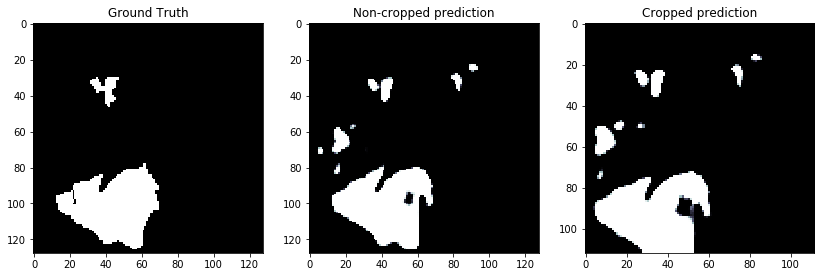

In [10]:
comparePredictions(5821)

Dice full ground truth to full image prediction = 0.8840
Dice cropped ground truth to cropped image prediction = 0.8744


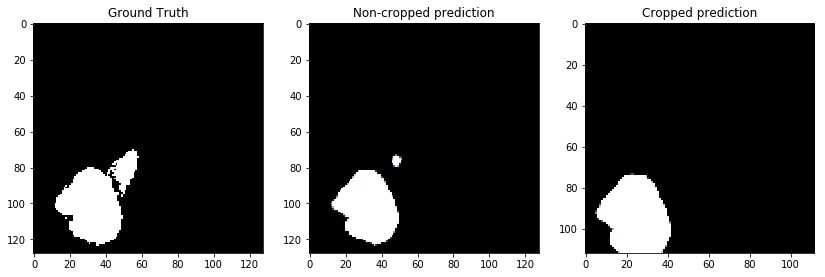

In [11]:
comparePredictions(400)

Dice full ground truth to full image prediction = 0.8384
Dice cropped ground truth to cropped image prediction = 0.8147


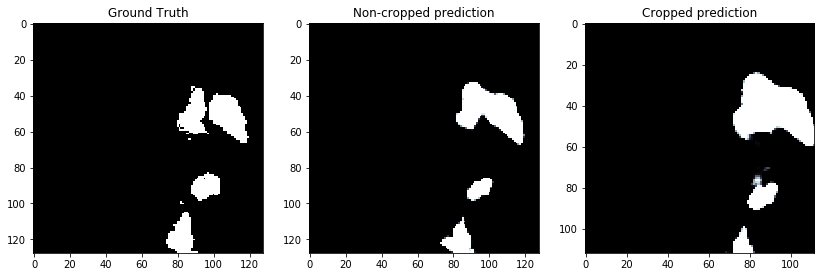

In [12]:
comparePredictions(520)

Dice full ground truth to full image prediction = 0.9709
Dice cropped ground truth to cropped image prediction = 0.9706


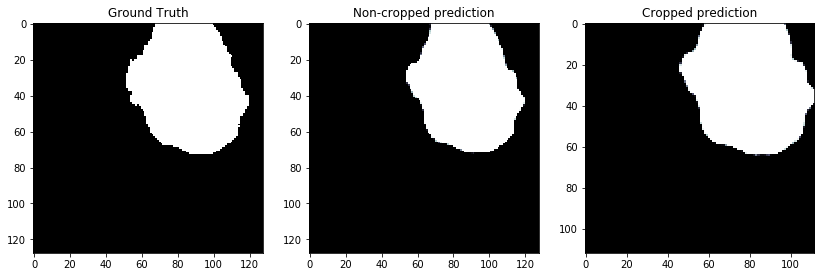

In [13]:
comparePredictions(1333)

Dice full ground truth to full image prediction = 0.9190
Dice cropped ground truth to cropped image prediction = 0.9210


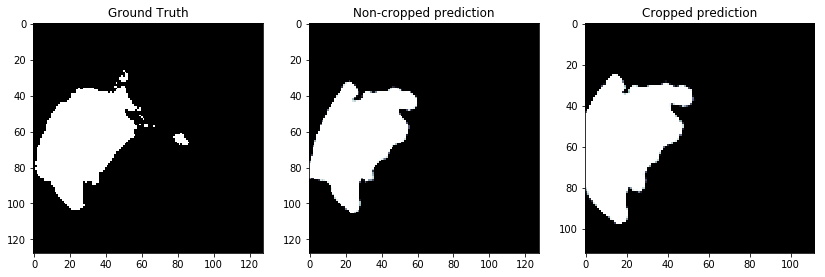

In [14]:
comparePredictions(2540)

Dice full ground truth to full image prediction = 0.6848
Dice cropped ground truth to cropped image prediction = 0.7699


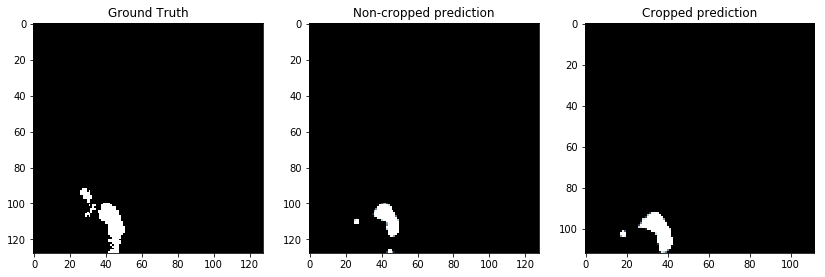

In [15]:
comparePredictions(5533)

Dice full ground truth to full image prediction = 0.9395
Dice cropped ground truth to cropped image prediction = 0.9390


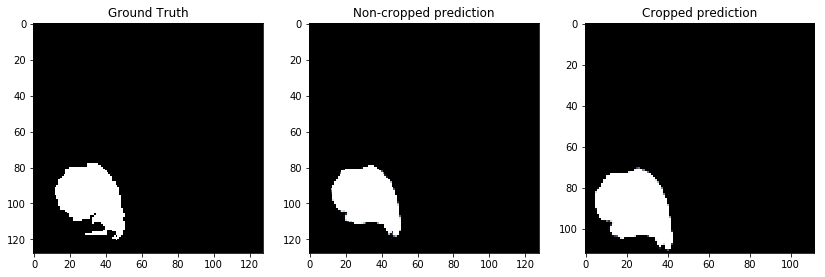

In [16]:
comparePredictions(2121)

Dice full ground truth to full image prediction = 0.9403
Dice cropped ground truth to cropped image prediction = 0.9375


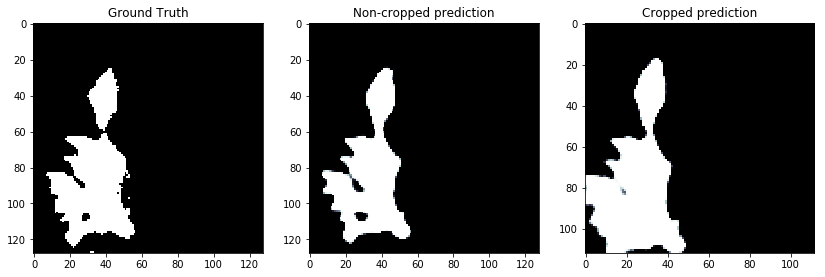

In [17]:
comparePredictions(4444)

Dice full ground truth to full image prediction = 0.8010
Dice cropped ground truth to cropped image prediction = 0.8240


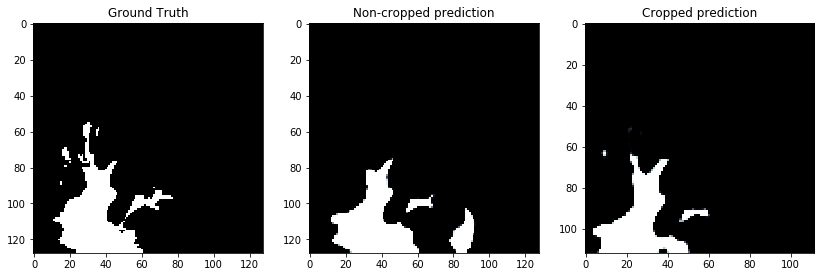

In [18]:
comparePredictions(3334)

Dice full ground truth to full image prediction = 0.8730
Dice cropped ground truth to cropped image prediction = 0.8690


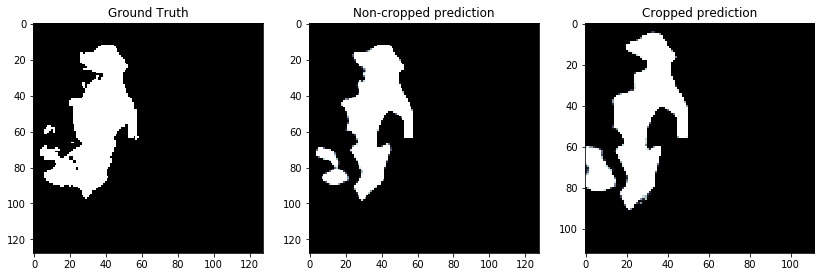

In [19]:
comparePredictions(2560)

Dice full ground truth to full image prediction = 0.4046
Dice cropped ground truth to cropped image prediction = 0.3646


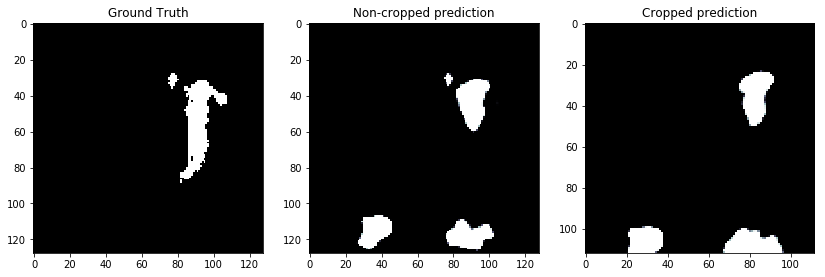

In [20]:
comparePredictions(88)

In [26]:
num_imgs = len(imgs)
dice_cropped_array = np.zeros(num_imgs)
dice_full_array = np.zeros(num_imgs)
dice_cropped_v_full = np.zeros(num_imgs)
for idx in range(num_imgs):
    dice_full_array[idx] = dice(test[idx,:,:,0], msk_transposed_full[idx,:,:,0])
    dice_cropped_array[idx] = dice(test_cropped[idx,:,:,0], msk_transposed_cropped[idx,:,:,0])
    dice_cropped_v_full[idx] = dice(msk_transposed_full_crop[idx,:,:,0], msk_transposed_cropped[idx,:,:,0])

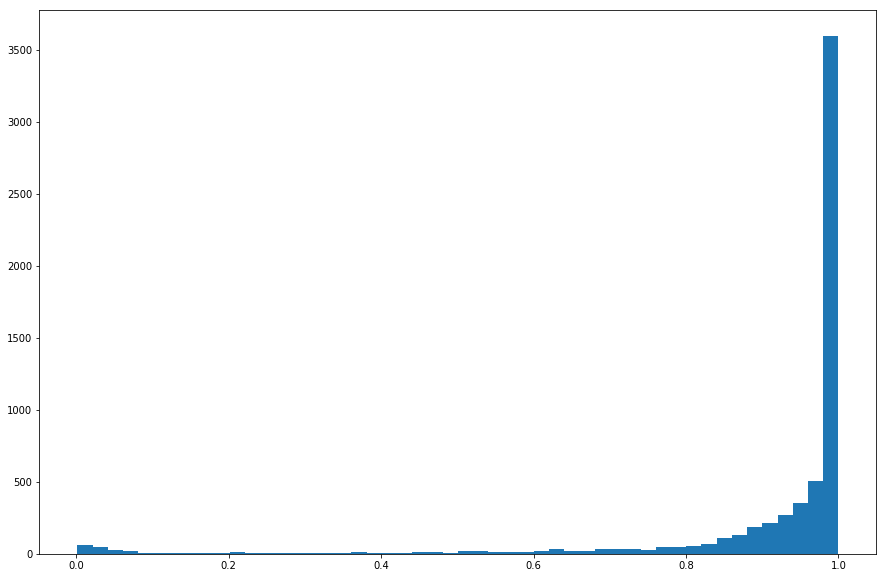

In [28]:
plt.figure(figsize=(15,10))
plt.hist(dice_cropped_v_full, bins=50);

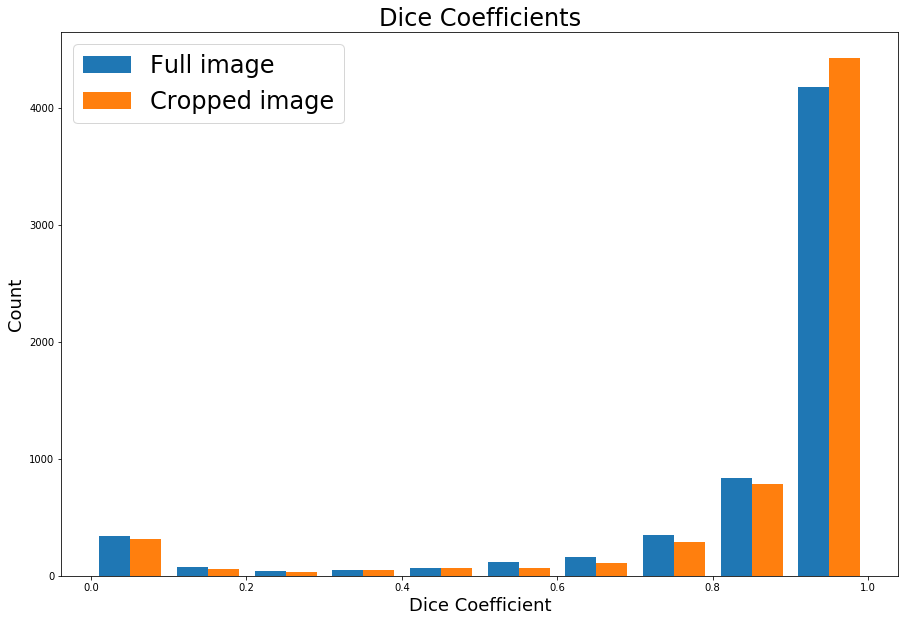

In [22]:
plt.figure(figsize=(15,10))
plt.hist([dice_full_array, dice_cropped_array]);
plt.legend(["Full image", "Cropped image"], fontsize=24);
plt.xlabel("Dice Coefficient", fontsize=18);
plt.ylabel("Count", fontsize=18);
plt.title("Dice Coefficients", fontsize=24);

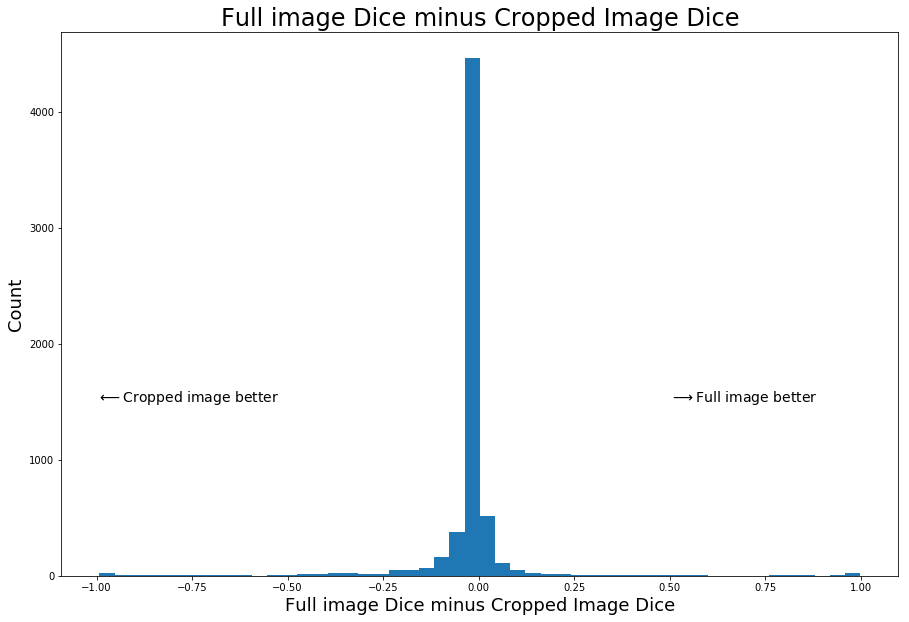

In [23]:
plt.figure(figsize=(15,10))
plt.hist(dice_full_array-dice_cropped_array, bins=50);
plt.title("Full image Dice minus Cropped Image Dice", fontsize=24);
plt.xlabel("Full image Dice minus Cropped Image Dice", fontsize=18);
plt.text(.5,1500, r"$\longrightarrow$Full image better", fontsize=14)
plt.text(-1,1500, r"$\longleftarrow$Cropped image better", fontsize=14)
plt.ylabel("Count", fontsize=18);

## Kolmogorov-Smirnoff (KS) Test
Perform a Kolmogorov-Smirnov two sample test. The null hypothesis is that the two data samples come from the same distribution.

In [24]:
from scipy.stats import ks_2samp

# 2 sample Kolmogorov-Smirnov test 
# Null Hypothesis is that both distributions come from same underlying distribution
# If p < 0.01, then reject the null hypothesis
[s, p_val] = ks_2samp(dice_full_array, dice_cropped_array)

if p_val < 0.01:
    print("Reject null hypothesis that distributions are the same (p <= {:.6f})".format(p_val))
else:
    print("Don't reject null hypothesis that distributions are the same (p = {:.6f})".format(p_val))

Reject null hypothesis that distributions are the same (p <= 0.000002)
